In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from ctapipe_io_lst import LSTEventSource
from ctapipe.image.extractor import LocalPeakWindowSum
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

from traitlets.config.loader import Config 
from lstchain.calib.camera.r0 import LSTR0Corrections

from lstchain.calib.camera.time_correction_calculate import TimeCorrectionCalculate 
from lstchain.calib.camera.pulse_time_correction import PulseTimeCorrection

plt.rcParams['font.size'] = 25

/home/pawel1/anaconda3/envs/cta/lib/python3.7/site-packages/corsikaio/subblocks/dtypes.py:20: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dict(**dt))
/home/pawel1/anaconda3/envs/cta/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Create coefficients to time correction and save to h5py file using camera calibration data

In [2]:
reader = LSTEventSource(
    input_url="/media/pawel1/ADATA HD330/20191124/LST-1.1.Run01625.0000.fits.fz",
    max_events=20000)

charge_config = Config({
    "LocalPeakWindowSum":{
        "window_shift":4,
        "window_width":11
    }
})

# Here you have to give path, where you want save calibration file
timeCorr = TimeCorrectionCalculate(calib_file_path='time_calib_run1625_new.h5',
                                  config=charge_config,)

config = Config({
        "LSTR0Corrections": {
            "pedestal_path": None, # if baseline correction was done in EVB
            "tel_id": 1,
            "r1_sample_start":2,
            "r1_sample_end":38
        }
})

lst_r0 = LSTR0Corrections(config=config)

for i, ev in enumerate(reader):
    if ev.r0.event_id%5000 == 0:
        print(ev.r0.event_id)
        
    lst_r0.calibrate(ev)                  # Cut in signal to avoid cosmic events      
    if ev.r0.tel[1].trigger_type == 1 and np.mean(ev.r1.tel[1].waveform[:, :, :]) > 100:
        timeCorr.calibrate_pulse_time(ev)

5000
10000
15000
20000


In [3]:
timeCorr.finalize()

# Apply time correction to camera calibration data

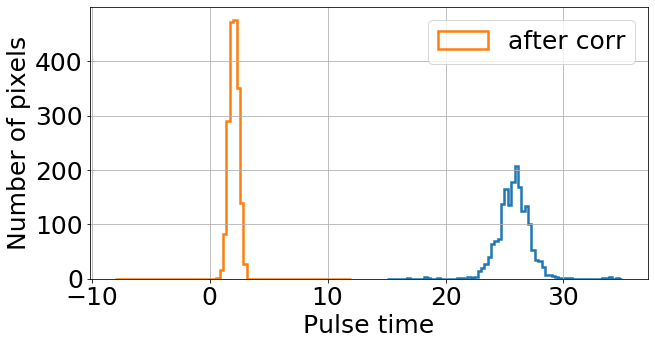

std before correction 1.41
std after correction 0.40


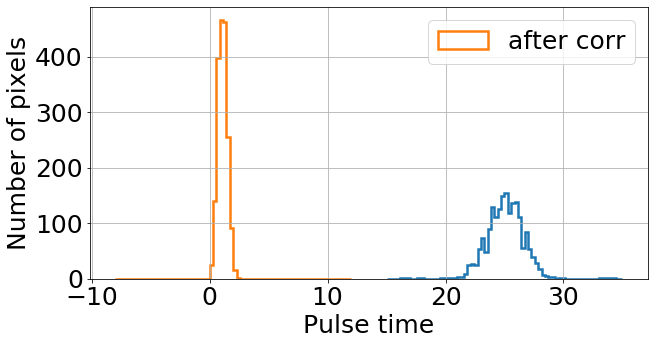

std before correction 1.60
std after correction 0.41


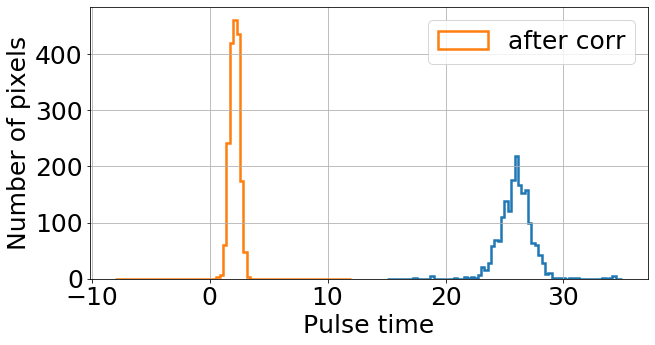

std before correction 1.41
std after correction 0.41


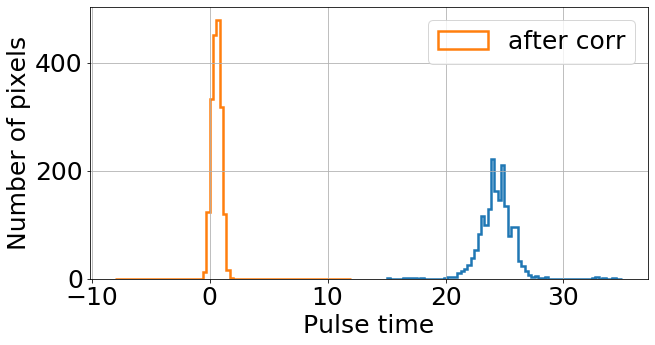

std before correction 1.43
std after correction 0.40


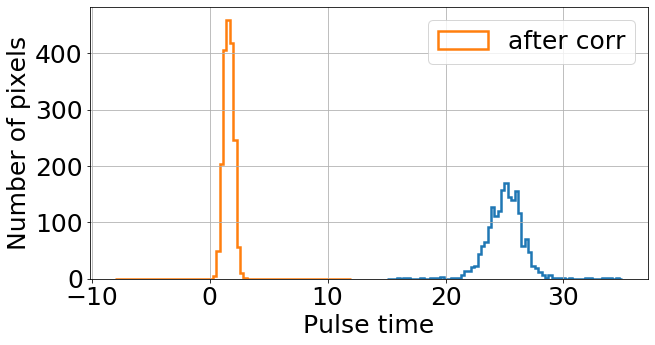

std before correction 1.55
std after correction 0.42


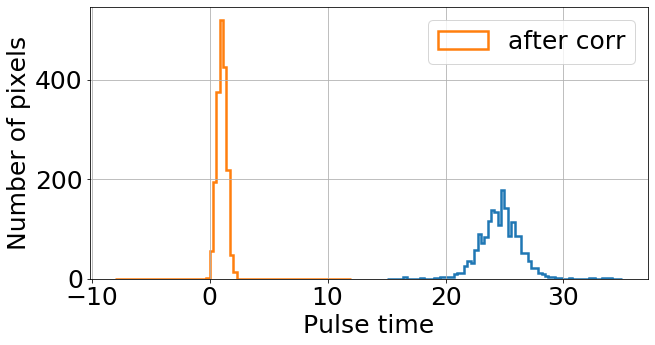

std before correction 1.74
std after correction 0.40


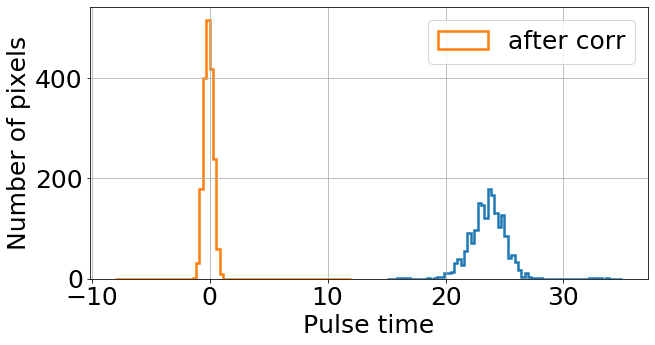

std before correction 1.58
std after correction 0.40


In [7]:
reader = LSTEventSource(
    input_url="/media/pawel1/ADATA HD330/20191124/LST-1.1.Run01625.0001.fits.fz",
    max_events=15)

pulse_corr = PulseTimeCorrection(calib_file_path='time_calib_run1625_new.h5')

config = Config({
        "LSTR0Corrections": {
            "pedestal_path": None, # if baseline correction was done in EVB
            "tel_id": 1,
            "r1_sample_start":2,
            "r1_sample_end":38
        }
})

lst_r0 = LSTR0Corrections(config=config)
extractor = LocalPeakWindowSum(window_width=11, window_shift=4)
gain = 0

for i, ev in enumerate(reader):
    if ev.r0.event_id%50 == 0:
        print(ev.r0.event_id)
        
    lst_r0.calibrate(ev)                  # Cut in signal to avoid cosmic events    
    if ev.r0.tel[1].trigger_type == 1 and np.mean(ev.r1.tel[1].waveform[:, :, :]) > 100:
        charge, pulse = extractor(ev.r1.tel[1].waveform[:, :, :])
        pulse_corr_array = pulse_corr.get_corr_pulse(ev, pulse)
        
        plt.figure(figsize=(10, 5))
        plt.hist(pulse[gain,:], bins=70, range=(15, 35), 
                 histtype='step', lw=2.5)
        plt.hist(pulse_corr_array[gain,:], bins=70, range=(-8, 12), 
                 histtype='step', lw=2.5, label="after corr")
        plt.xlabel("Pulse time")
        plt.ylabel("Number of pixels")
        plt.legend()
        plt.grid(True)
        plt.show()
        print("std before correction {:.2f}".format(np.std(pulse)))
        print("std after correction {:.2f}".format(np.std(pulse_corr_array)))

# Apply time correction to cosmic events 

In [4]:
input_file_1 = "/media/pawel1/ADATA HD330/20191124/LST-1.1.Run01627.0000.fits.fz"

reader = LSTEventSource(input_url=input_file_1, max_events=35)

config_corr = Config({
    "LSTR0Corrections": {
        "pedestal_path": None, # For run with baseline correction online
        "offset":  400,
        "tel_id": 1,
        "r1_sample_start":2,
        "r1_sample_end":38
    }
})
tel_id = 1

lst_r0 = LSTR0Corrections(config=config_corr)

extractor = LocalPeakWindowSum(window_width=11, window_shift=4)
gain = 0

pulse_corr = PulseTimeCorrection(calib_file_path='time_calib_run1625.h5')

for i, ev in enumerate(reader):
    if ev.r0.event_id%10 == 0:
        print(ev.r0.event_id)
    
    lst_r0.calibrate(ev)                       # Cut to see some signal from cosmic events  
    if ev.r0.tel[tel_id].trigger_type == 1 and np.sum(ev.r1.tel[tel_id].waveform[gain, :, 2:38]>600) > 10:
        
        charge, pulse_time = extractor(ev.r1.tel[tel_id].waveform[:, :, :])
        pulse_corr_array = pulse_corr.get_corr_pulse(ev, pulse_time)
        
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
        geom = ev.inst.subarray.tel[tel_id].camera
        disp1 = CameraDisplay(geom, ax=ax[0])
        disp1.image = pulse_time[gain, :]
        disp1.add_colorbar(ax=ax[0], label="time [ns]")
        disp1.cmap = 'gnuplot2'
        ax[0].set_title("Pulse time")
        
        disp2 = CameraDisplay(geom, ax=ax[1])
        disp2.image = pulse_corr_array[0, :]
        disp2.add_colorbar(ax=ax[1], label="time [ns]")
        disp2.cmap = 'gnuplot2'
        ax[1].set_title("Pulse time correction")
        plt.tight_layout()        
        plt.show()

NameError: name 'LSTR0Corrections' is not defined

In [4]:
import ctapipe

In [5]:
ctapipe.__version__

'0.7.0'

In [71]:
input_file_1 = "/media/pawel1/ADATA HD330/20191124/LST-1.1.Run01625.0000.fits.fz"

reader = LSTEventSource(input_url=input_file_1, max_events=35)

lst_r0 = LSTR0Corrections(offset=400)

extractor = LocalPeakWindowSum(window_width=11, window_shift=4)

for i, ev in enumerate(reader):
    lst_r0.calibrate(ev) 
    charge, pulse_time = extractor(ev.r1.tel[tel_id].waveform[:, :, 2:38])
    print(np.where(pulse_time[0,:]<-100))

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([  17,  637,  653,  753, 1452, 1811]),)
(array([], dtype=int64),)
(array([ 277,  322,  577,  878, 1081, 1208]),)
(array([], dtype=int64),)
(array([ 628, 1035, 1098, 1566, 1648]),)
(array([], dtype=int64),)
(array([ 467, 1159]),)
(array([], dtype=int64),)
(array([ 327, 1542]),)
(array([], dtype=int64),)
(array([194, 248, 305, 789, 793]),)
(array([], dtype=int64),)
(array([  27,  287,  538,  614, 1493, 1839]),)
(array([], dtype=int64),)
(array([ 260,  501,  835, 1168, 1470, 1483, 1528, 1546, 1694]),)
(array([], dtype=int64),)
(array([ 232,  604,  915, 1119, 1244, 1603]),)
(array([], dtype=int64),)
(array([ 605,  761, 1213, 1806]),)
(array([], dtype=int64),)
(array([ 323,  684,  816,  878,  940, 1048, 1373]),)
(array([], dtype=int64),)
(array([1148, 1479, 1779]),)
(array([ 348, 1309, 1366]),)
(array([], dtype=int64),)
(array([ 762, 1153]),)
(array([], dtype=int64),)
(array([ 11, 159, 311, 855]),)
(array([ 601, 1310]),)
(array([], 

In [72]:
np.where(pulse_time[0,:]<-100)

(array([ 580,  641, 1551, 1664]),)

In [75]:
pulse_time[0, 580]

-119.0

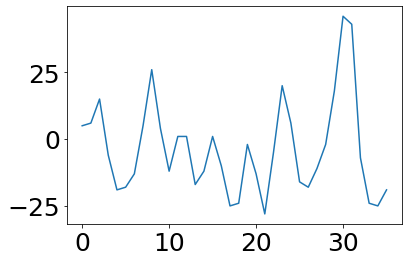

In [74]:
plt.plot(ev.r1.tel[tel_id].waveform[0, 580, :])

1.5433930505100661


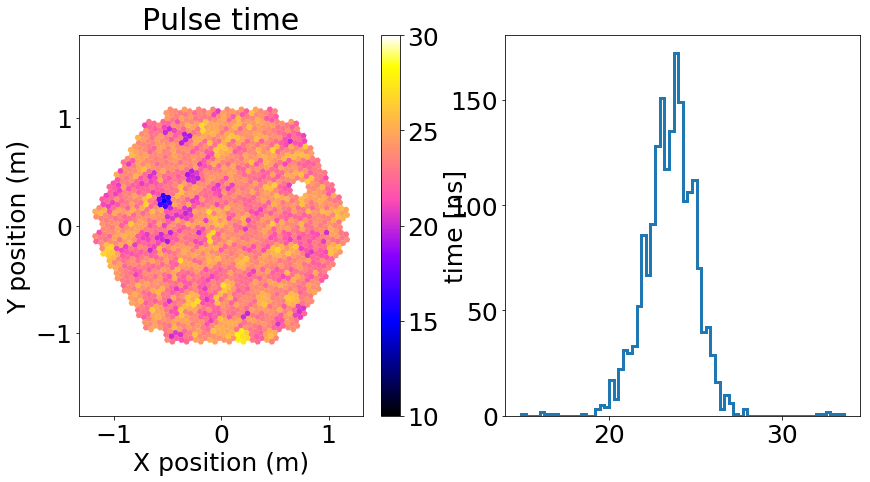

In [6]:
tel_id = 1
gain = 0

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
geom = ev.inst.subarray.tel[tel_id].camera
disp1 = CameraDisplay(geom, ax=ax[0])
disp1.image = pulse[gain, :]
disp1.add_colorbar(ax=ax[0], label="time [ns]")
disp1.cmap = 'gnuplot2'
disp1.set_limits_minmax(10, 30)
ax[0].set_title("Pulse time")

ax[1].hist(pulse[gain, :], bins=70, histtype='step', lw=3)

print(np.std(pulse[gain, :]))

0.37991817816884443


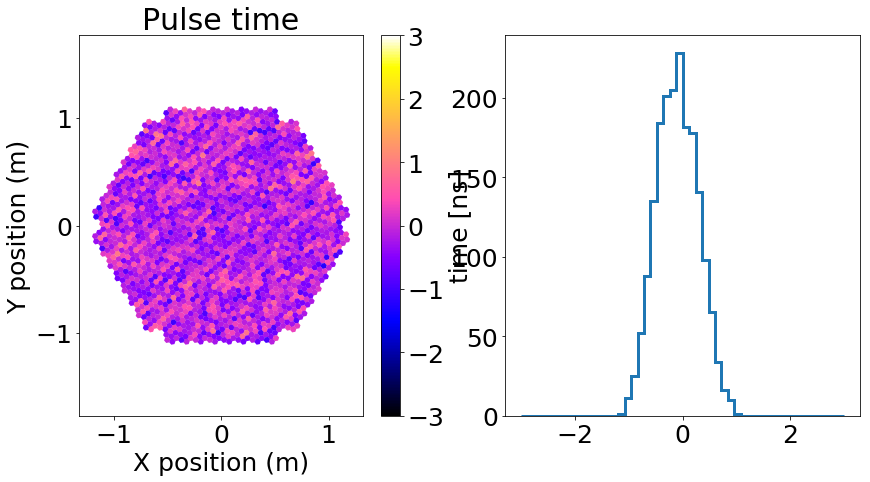

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
geom = ev.inst.subarray.tel[tel_id].camera
disp1 = CameraDisplay(geom, ax=ax[0])
disp1.image = pulse_corr_array[gain, :]
disp1.add_colorbar(ax=ax[0], label="time [ns]")
disp1.set_limits_minmax(-3, 3)
disp1.cmap = 'gnuplot2'
ax[0].set_title("Pulse time")

ax[1].hist(pulse_corr_array[gain, :], bins=50, histtype='step', lw=3, range=(-3, 3))

print(np.std(pulse_corr_array[gain, :]))